# Prueba técnica PACTIA

## 1. Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from scipy.stats import shapiro
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt

import warnings
warnings.filterwarnings('ignore')

#! pip install pmdarima
from pmdarima.arima import auto_arima


In [2]:
train = pd.read_excel('./train.xlsx')
test = pd.read_excel('./test.xlsx')
ipc = pd.read_excel('./ipc.xlsx')
trm = pd.read_excel('./trm.xlsx')
desempleo = pd.read_excel('./tasa_desempleo.xlsx')



### 1.1 Descripción variables


- **Trafico_dia** : Número de personas que ingresan al centro comercial por día.
- **Categoria** : Clases en las que se enmarcan los negocios dentro del centro comercial.
- **Area_total_ocupada** : Espacio que actualmente se encuentra en arriendo por los locales comerciales.
- **IPC** : Indicador macroeconómico del nivel de precios. (utilizaremos el dato mensual en su respectiva variación anual)
- **Desempleo** : Tasa de referencia sobre el desempleo en la ciudad.
- **TRM** : Tasa de referencia del USD/COP.
- **Ventas_diarias** : Mide los ingresos diarios en COP. Es la variable objetivo.


## 2. Análisis exploratorio

###  Análisis evolución Ventas-m2 

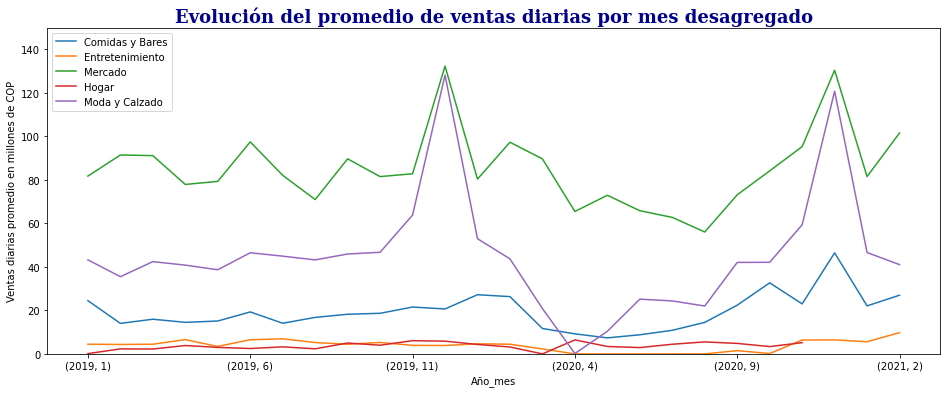

In [80]:
df_graph = train[["mes","año","categoria","venta_diaria","area_total_ocupada"]]

df_graph["venta_diaria"] = df_graph["venta_diaria"]/1000000

def año_mes(fila):
    resultado = str(fila["mes"]) + str(fila["año"])
    return resultado

df_graph["año_mes"]= df_graph.apply(año_mes, axis=1)

def ganancia_m2(fila):
    resultado1 = fila["venta_diaria"] / fila["area_total_ocupada"]
    return resultado1

df_graph["ganancia_m2"]= df_graph.apply(ganancia_m2, axis=1)

df_1 = df_graph[df_graph["categoria"] == "COMIDAS Y BARES"]
df_1 = df_1.groupby(by= ["año","mes"]).mean()
df_1["venta_diaria"].plot(label = "Comidas y Bares")

df_2 = df_graph[df_graph["categoria"] == "ENTRETENIMIENTO"]
df_2 = df_2.groupby(by= ["año","mes"]).mean()
df_2["venta_diaria"].plot(label = "Entretenimiento")

df_3 = df_graph[df_graph["categoria"] == "HIPERMERCADO"]
df_3 = df_3.groupby(by= ["año","mes"]).mean()
df_3["venta_diaria"].plot(label = "Mercado")

df_4 = df_graph[df_graph["categoria"] == "HOGAR"]
df_4 = df_4.groupby(by= ["año","mes"]).mean()
df_4["venta_diaria"].plot(label = "Hogar")

df_5 = df_graph[df_graph["categoria"] == "MODA Y CALZADO"]
df_5 = df_5.groupby(by= ["año","mes"]).mean()
df_5["venta_diaria"].plot(label = "Moda y Calzado")

plt.ylabel("Ventas diarias promedio en millones de COP", size = 10)
plt.xlabel("Año_mes", size = 10)

plt.title("Evolución del promedio de ventas diarias por mes desagregado", 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})

plt.rcParams["figure.figsize"] = (16, 6)
plt.ylim(0,150)
plt.legend()
plt.show()




**Del grafico anterior destacamos 4 hechos relevantes:**

-	Las categorías que mas aportan en ingresos al centro comercial en su respectivo orden son Mercado, Moda/calzado y Comidas/Bares.

-	Se presenta un comportamiento cíclico, es decir, a medida que se acerca el fin de año hay un aumento considerable en las ventas. Es algo natural en el comportamiento de mercado de la región.

-	La evolución de las ventas tanto pre como post pandemia. Se destaca la categoría de mercado la cual siempre mantuvo un nivel de ventas estable, salvo en 2 meses, teniendo en cuenta que eran los únicos locales disponibles para la venta en el periodo del encierro obligatorio. Sin embargo, se puede evidenciar una recuperación temprana en todas las categorías a finales de 2020 donde se alcanzaban niveles de ventas cercanos a los vistos durante el 2019. 

-	El incremento de las ventas online permitió que categorías como hogar y comidas/bares permanecieran con un nivel de ventas aceptable que les permitiera sostener su capital de trabajo y en ese sentido mantenerse a flote hasta el retorno de la gente hacia los centros comerciales.


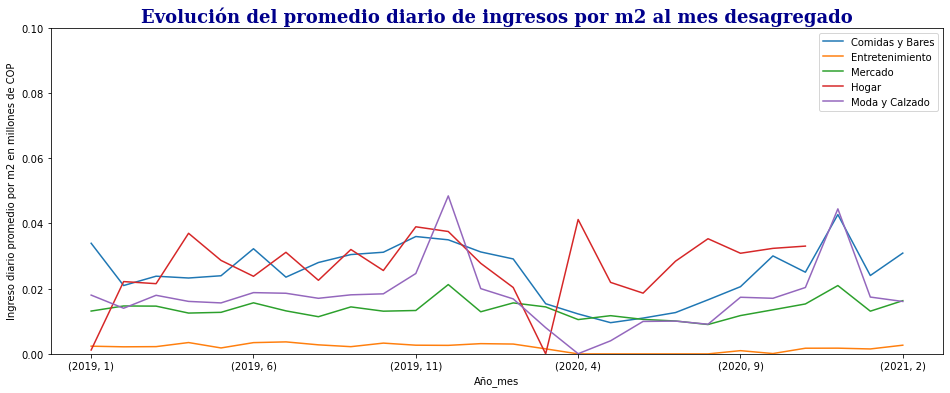

In [4]:
df_11 = df_graph[df_graph["categoria"] == "COMIDAS Y BARES"]
df_11 = df_11.groupby(by= ["año","mes"]).mean()
df_11["ganancia_m2"].plot(label = "Comidas y Bares")

df_22 = df_graph[df_graph["categoria"] == "ENTRETENIMIENTO"]
df_22 = df_22.groupby(by= ["año","mes"]).mean()
df_22["ganancia_m2"].plot(label = "Entretenimiento")

df_33 = df_graph[df_graph["categoria"] == "HIPERMERCADO"]
df_33 = df_33.groupby(by= ["año","mes"]).mean()
df_33["ganancia_m2"].plot(label = "Mercado")

df_44 = df_graph[df_graph["categoria"] == "HOGAR"]
df_44 = df_44.groupby(by= ["año","mes"]).mean()
df_44["ganancia_m2"].plot(label = "Hogar")

df_55 = df_graph[df_graph["categoria"] == "MODA Y CALZADO"]
df_55 = df_55.groupby(by= ["año","mes"]).mean()
df_55["ganancia_m2"].plot(label = "Moda y Calzado")

plt.ylabel("Ingreso diario promedio por m2 en millones de COP", size = 10)
plt.xlabel("Año_mes", size = 10)

plt.title("Evolución del promedio diario de ingresos por m2 al mes desagregado", 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})

plt.rcParams["figure.figsize"] = (16, 6)
plt.ylim(0,0.1)
plt.legend()
plt.show()

Al evaluar el ingreso/m2 encontramos que las categorías con mayor relación y de cierto modo más eficientes son Hogar y Comidas/Bares. Así mismo, se puede evidenciar que la categoría de mercado a pesar de ser por mucho la que mas vende es a su vez la que más m2 requiere en sus instalaciones, es algo que normalmente sucede con las grandes superficies. Evidenciamos también que la categoría de Entretenimiento es la que menos aporta en ventas y en relación con su ocupación tampoco refleja una suma representativa a los ingresos totales. Por último, destacamos la categoría de calzado/moda cuyo comportamiento se ve altamente afectado por las épocas de fin de año donde logra máximos importantes. 

In [5]:
df_6 = df_graph[df_graph["categoria"] == "MODA INFANTIL"]
df_6["venta_diaria"].sum()/df_graph["venta_diaria"].sum()

0.0019051101900996554

In [6]:
df_7 = df_graph[df_graph["categoria"] == "TECNOLOGIA"]
df_7["venta_diaria"].sum()/df_graph["venta_diaria"].sum()

0.00045761345106527817

In [7]:
df_8 = df_graph[df_graph["categoria"] == "OTROS"]
df_8["venta_diaria"].sum()/df_graph["venta_diaria"].sum()

0.0023392262485603444

Cabe mencionar que dentro del conjunto de datos se encuentran otras 3 categorías (Moda infantil, Tecnología, Otros) que no fueron incluidas dentro de los análisis anteriores. Se tomó la decisión porque sumando las ventas totales de estos solo representan el  0.5% del total de ventas y adicionalmente hacen su primera aparición tiempo después de la fecha inicial del análisis.

### Análisis trafico dia

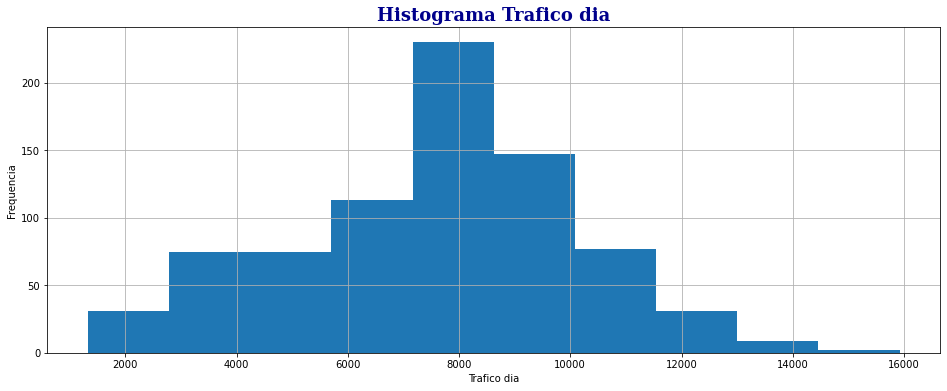

In [8]:
df_trafico = train[["fecha","trafico_dia","mes","año"]]

df_trafico["trafico_dia"] = round(df_trafico["trafico_dia"])
df_trafico = df_trafico.drop_duplicates()
df_trafico["trafico_dia"].hist()
plt.xlabel("Trafico dia", size = 10)
plt.ylabel("Frequencia", size = 10)
plt.title("Histograma Trafico dia",
         fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})

plt.show()


In [9]:
len(df_trafico[df_trafico["trafico_dia"]<10000])/len(df_trafico["trafico_dia"])

0.839240506329114

En el grafico anterior se evidencia como se distribuye el numero diario de personas que ingresan al centro comercial. Encontramos que en promedio ingresan 7500 personas por día aproximadamente. Y en general cerca del 85% del tráfico diario se encuentra entre 2.000 y 10.000 personas. 

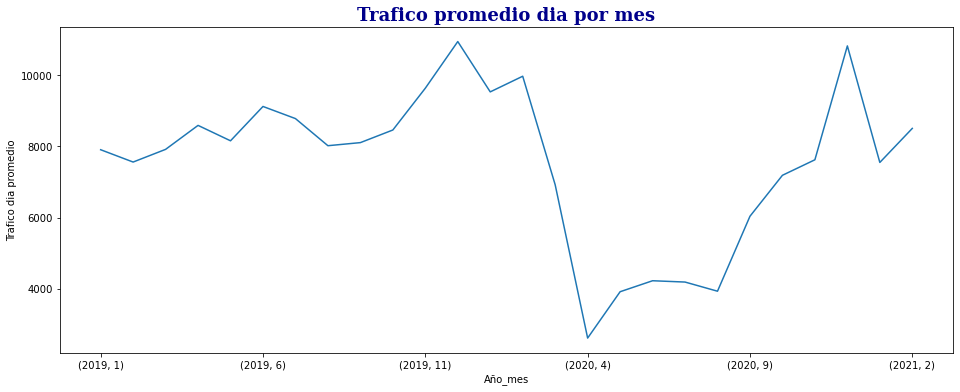

In [10]:
df_trafico1 = df_trafico.groupby(by= ["año","mes"]).mean()
df_trafico1["trafico_dia"].plot(label = "trafico_dia")

plt.ylabel("Trafico dia promedio", size = 10)
plt.xlabel("Año_mes", size = 10)

plt.title("Trafico promedio dia por mes", 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})

plt.show()


In [11]:
df_trafico["trafico_dia"].mean()

7544.817721518987

Como hemos mencionado previamente el ingreso diario promedio al centro comercial es de 7500 personas. Este dato, claramente, ha sido afectado por la época de pandemia donde el ingreso fue limitado y solo ingresaban alrededor de 1.000 o 2.000 personas al centro comercial.  Sin embargo, en las fechas anteriores y posteriores al encierro obligatorio se puede evidenciar ingresos diarios por encima de los 8.000, Así mismo, se evidencia un alto flujo en diciembre lo cual se refleja con la época en que las ventas son mayores. Por tanto, se puede intuir que hay una relación directa entre el tráfico día y las ventas diarias. 

### Análisis descriptivo Ventas-m2 por categorías

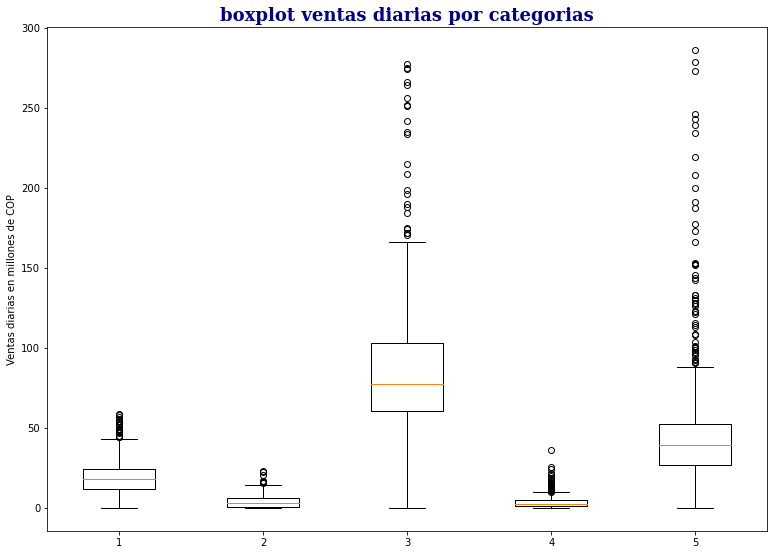

In [12]:
box1 = df_graph[df_graph["categoria"] == "COMIDAS Y BARES"]
box1 =  box1["venta_diaria"]

box2 = df_graph[df_graph["categoria"] == "ENTRETENIMIENTO"]
box2 =  box2["venta_diaria"]

box3 = df_graph[df_graph["categoria"] == "HIPERMERCADO"]
box3 =  box3["venta_diaria"]

box4 = df_graph[df_graph["categoria"] == "HOGAR"]
box4 =  box4["venta_diaria"]

box5 = df_graph[df_graph["categoria"] == "MODA Y CALZADO"]
box5 =  box5["venta_diaria"]

data = [box1, box2, box3, box4,box5]
 
fig = plt.figure(figsize =(10, 7))
 
ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(data)

plt.ylabel("Ventas diarias en millones de COP", size = 10)

plt.title("boxplot ventas diarias por categorias", 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})


plt.show()

**Del grafico podemos entender con un mayor nivel de detalle el comportamiento de las ventas diarias para cada una de las categorías:**

1. **COMIDAS Y BARES:** En promedio el nivel de ventas diaria es cercano a 20 millones, con un máximo cercano a los 60 millones. Se consideran niveles atípicos a los datos registrados por encima de los 48 millones aproximadamente donde se encuentra el límite superior del boxplot. 

2. **ENTRETENIMIENTO:** En promedio el nivel de ventas diaria es cercano a 1 millón, con un máximo cercano a los 25 millones. Se consideran niveles atípicos a los datos registrados por encima de los 18 millones aproximadamente donde se encuentra el límite superior del boxplot. Es la categoría con menores ingresos y menores máximos encontrados.

3. **HIPERMERCADO:** En promedio el nivel de ventas diaria es cercano a 75 millones, con un máximo cercano a los 270 millones. Se consideran niveles atípicos a los datos registrados por encima de los 160 millones aproximadamente donde se encuentra el límite superior del boxplot. Es la categoría con mayores  ingresos y con una distribución más homogénea de los datos.

4. **HOGAR:** En promedio el nivel de ventas diaria es cercano a 1 millón, con un máximo cercano a los 40 millones. Se consideran niveles atípicos a los datos registrados por encima de los 15 millones aproximadamente donde se encuentra el límite superior del boxplot. Junto con Entretenimiento es la categoría con menores ingresos a pesar de tener máximos importantes cercanos a los promedios de categorías importantes como Comidas/Bares y Calzado/Moda.

5. **MODA Y CALZADO:** En promedio el nivel de ventas diaria es cercano a 40 millones, con un máximo cercano a los 280 millones. Se consideran niveles atípicos a los datos registrados por encima de los 80 millones aproximadamente donde se encuentra el límite superior del boxplot. Es junto a Hipermercado la categoría con mayores  ingresos resaltando el hecho de que presentan incluso mayores máximos que hipermercado.


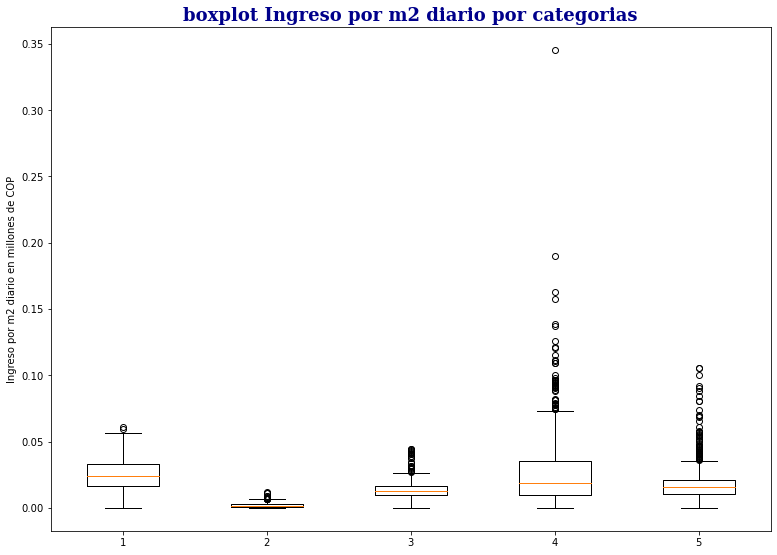

In [13]:
box11 = df_graph[df_graph["categoria"] == "COMIDAS Y BARES"]
box11 =  box11["ganancia_m2"]

box22 = df_graph[df_graph["categoria"] == "ENTRETENIMIENTO"]
box22 =  box22["ganancia_m2"]

box33 = df_graph[df_graph["categoria"] == "HIPERMERCADO"]
box33 =  box33["ganancia_m2"]

box44 = df_graph[df_graph["categoria"] == "HOGAR"]
box44 =  box44["ganancia_m2"]

box55 = df_graph[df_graph["categoria"] == "MODA Y CALZADO"]
box55 =  box55["ganancia_m2"]

data = [box11, box22, box33, box44,box55]
 
fig = plt.figure(figsize =(10, 7))
 
ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(data)

plt.ylabel("Ingreso por m2 diario en millones de COP", size = 10)

plt.title("boxplot Ingreso por m2 diario por categorias", 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})


plt.show()

**Del grafico podemos entender con un mayor nivel de detalle el comportamiento de los ingresos/m2 para cada una de las categorías:**

1. **COMIDAS Y BARES:** En promedio el nivel de ingresos/m2 diario es cercano a 25.000 pesos, con un máximo cercano a los 60.000 pesos. Se consideran niveles atípicos a los datos registrados por encima de los 55.000 pesos aproximadamente donde se encuentra el límite superior del boxplot. 

2. **ENTRETENIMIENTO:** En promedio el nivel de ingresos/m2 diario es cercano a 1.000 pesos, con un máximo cercano a los 20.000 pesos. Se consideran niveles atípicos a los datos registrados por encima de los 10.000 pesos aproximadamente donde se encuentra el límite superior del boxplot. Es la categoría con menor relación ingreso/m2 y menores máximos encontrados.

3. **HIPERMERCADO:** En promedio el nivel de ingresos/m2 diario es cercano a 20.000 pesos, con un máximo cercano a los 50.000 pesos. Se consideran niveles atípicos a los datos registrados por encima de los 27.000 pesos aproximadamente donde se encuentra el límite superior del boxplot. 

4. **HOGAR:** En promedio el nivel de ingresos/m2 diario es cercano a 22.000 pesos, con un máximo cercano a los 350.000 pesos. Se consideran niveles atípicos a los datos registrados por encima de los 75.000 pesos aproximadamente donde se encuentra el límite superior del boxplot. Es la categoría con mejor relación ingreso/m2 y los mayores máximos encontrados.

5. **MODA Y CALZADO:** En promedio el nivel de ingresos/m2 diario es cercano a 20.000 pesos, con un máximo cercano a los 100.000 pesos. Se consideran niveles atípicos a los datos registrados por encima de los 30.000 pesos aproximadamente donde se encuentra el límite superior del boxplot. Es junto a Hogar la categoria que presenta los mayores máximos.

### Análisis de correlaciones 

In [14]:
desempleo["año_mes"]= desempleo.apply(año_mes, axis=1)
desempleo = desempleo[["año_mes","Tasa desempleo"]]
ipc["año_mes"]= ipc.apply(año_mes, axis=1)
Medellin_ipc = ipc[ipc["Orden"]== 3]
Medellin_ipc = Medellin_ipc[["año_mes","Variación anual %"]]

result = pd.merge(train,trm, how ="left")
result["año_mes"]= result.apply(año_mes, axis=1)


In [15]:
df_corr = result[["año_mes","trafico_dia","venta_diaria","area_total_ocupada","trm"]]
df_corr = pd.merge(df_corr,desempleo, how ="left")
df_corr = pd.merge(df_corr,Medellin_ipc, how ="left")

In [16]:
df_corr = df_corr[["trafico_dia","venta_diaria","area_total_ocupada","trm","Tasa desempleo","Variación anual %"]]
corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,trafico_dia,venta_diaria,area_total_ocupada,trm,Tasa desempleo,Variación anual %
trafico_dia,1.000000,0.273897,0.018317,-0.560080,-0.671331,0.365578
venta_diaria,0.273897,1.000000,0.737581,-0.132824,-0.165017,0.115418
area_total_ocupada,0.018317,0.737581,1.000000,-0.037375,-0.048353,0.089930
trm,-0.560080,-0.132824,-0.037375,1.000000,0.684214,-0.535070
Tasa desempleo,-0.671331,-0.165017,-0.048353,0.684214,1.000000,-0.699634
Variación anual %,0.365578,0.115418,0.089930,-0.535070,-0.699634,1.000000


Partiendo de la variable objetivo (Ventas diarias), se encuentra que la variable con mayor influencia lineal es el área total ocupada con un coeficiente de correlación de 0.74 (correlación alta), seguido de la variable tráfico día con un coeficiente de correlación de 0.27 (correlación baja). Es importante mencionar, que a pesar de que las demás variables (de tipo externo) presentan una correlación muy baja pueden ser tenidas en cuenta de manera exploratoria inicial en el planteamiento de los modelos y conforme los resultados validar su significancia. Resaltamos también, el signo negativo en la correlación de la trm y la tasa de desempleo en donde esperamos que ante un incremento en dichas variables haya un decrecimiento en las ventas, lo cual consideramos lógico y acertado.

## 3. Planteamiento de Modelos

## 3.1 Modelos de Regresion lineal 

Para abordar el problema en cuestión, se considera en primera instancia la modelación a través de un modelo de regresión lineal múltiple en el que podamos representar la variable objetivo por medio de las variables dadas en el conjunto de datos. Para ello, se estima un primer modelo con las 2 variables que presentan mayor correlación frente a la variable objetivo, posteriormente un segundo modelo con las variables externas y las internas sin tener en cuenta factores categóricos y finalmente un modelo con todas las variables. A continuación, se presentan los resultados obtenidos junto con sus respectivos análisis:

### Modelo regresion lineal 1

In [17]:
data_mods = result[["año_mes","trafico_dia","categoria","venta_diaria","area_total_ocupada","trm"]]
data_mods = pd.merge(data_mods,desempleo, how ="left")
data_mods = pd.merge(data_mods,Medellin_ipc, how ="left")

In [18]:
data_mod1 = data_mods[["trafico_dia","area_total_ocupada"]]

In [19]:
y = data_mods["venta_diaria"]

In [20]:
y = y/1000000

In [21]:
data_mod1 = sm.add_constant(data_mod1, prepend=True)
modelo1 = sm.OLS(endog=y, exog=data_mod1,)
modelo1 = modelo1.fit()
print(modelo1.summary())

                            OLS Regression Results                            
Dep. Variable:           venta_diaria   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     3421.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:33:56   Log-Likelihood:                -19972.
No. Observations:                4343   AIC:                         3.995e+04
Df Residuals:                    4340   BIC:                         3.997e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -29.3632      1

De acuerdo con el resumen estadístico, nos encontramos que los parámetros ajustados en la regresión son significativos dado que su respectivo valor_P del estadístico t es < 0.05. Así mismo, el modelo en general es significativo dado que el valor_P del estadístico F es < 0.05. Por otra parte, el modelo explica en un 61.2% la variación en la ventas.

In [22]:
test = pd.merge(test,trm, how ="left")
test["año_mes"]= test.apply(año_mes, axis=1)

In [23]:
data_test = test[["año_mes","trafico_dia","categoria","venta_diaria","area_total_ocupada","trm"]]
data_test = pd.merge(data_test,desempleo, how ="left")
data_test = pd.merge(data_test,Medellin_ipc, how ="left")

In [24]:
data_test1 = data_test[["trafico_dia","area_total_ocupada"]]

In [25]:
data_test1 = sm.add_constant(data_test1)

In [26]:
y_test_cv = data_test.venta_diaria/1000000

In [27]:
#define cross-validation method to use
cv = LeaveOneOut()

#build multiple linear regression model
model = LinearRegression()

#use LOOCV to evaluate model
scores = cross_val_score(model, data_mod1, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view RMSE
sqrt(mean(absolute(scores)))


24.065329165987333

In [28]:
modelo1_test = modelo1.predict(data_test1)

In [29]:
MSE1_test = sum((data_test.venta_diaria/1000000 - modelo1_test)**2)/(213) # el denominador es igual a el numero de datos - numero de parametros estimados - 1

In [30]:
print(MSE1_test) # mse desagregado , del modelo estimado

558.7077622429425


In [31]:
Residual_standard_error1 = MSE1_test**0.5
Residual_standard_error1

23.636999857066094

In [32]:
modelo1_test1 = pd.DataFrame({"fecha":test.fecha, "Prediccion": modelo1_test})

In [33]:
modelo1_test1 = modelo1_test1.groupby("fecha").sum()

In [34]:
data_real =  pd.DataFrame({"fecha":test.fecha, "venta_real":test.venta_diaria/1000000})

In [35]:
data_real = data_real.groupby("fecha").sum()

In [36]:
sum((data_real.venta_real-modelo1_test1.Prediccion)**2)/(31) ## MSE1 diario consolidado

4429.840940198519

In [37]:
sum(abs(data_real.venta_real-modelo1_test1.Prediccion))/(31) ## MAE1 diario consolidado

54.458556108146155

Para validar el modelo se utilizaron diferentes métricas, en un principio se realizó validación cruzada para estimar a partir de los datos de **entrenamiento** en cuanto podría estar el error del modelo a la hora de ser utilizado. Posteriormente, se realizó el pronóstico y la validación del mismo (MSE Test) a partir de la data de **test** utilizando todos los registros disponibles. Por último, dado que el objetivo es predecir las ventas diarias consolidado, entonces se calcularon medidas como el MSE y MAE para estimar el error del modelo en los datos diarios consolidados.

### Modelo regresion lineal 2

In [38]:
data_mod2 = data_mods[["trafico_dia","area_total_ocupada","trm","Tasa desempleo","Variación anual %"]]

In [39]:
data_mod2 = sm.add_constant(data_mod2, prepend=True)
modelo2 = sm.OLS(endog=y, exog=data_mod2,)
modelo2 = modelo2.fit()
print(modelo2.summary())

                            OLS Regression Results                            
Dep. Variable:           venta_diaria   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1392.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:34:30   Log-Likelihood:                -19948.
No. Observations:                4343   AIC:                         3.991e+04
Df Residuals:                    4337   BIC:                         3.995e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -57.3857      8

De acuerdo con el resumen estadístico, nos encontramos que el parámetro ajustado para la variable de la inflación no es significativo dado que su respectivo valor_P del estadístico t ( 0.338)es > 0.05. Por tanto, procedemos a estimar nuevamente la regresión sin dicha variable.

In [40]:
data_mod22 = data_mods[["trafico_dia","area_total_ocupada","trm","Tasa desempleo"]]

In [41]:
data_mod22 = sm.add_constant(data_mod22, prepend=True)
modelo22 = sm.OLS(endog=y, exog=data_mod22,)
modelo22 = modelo22.fit()
print(modelo22.summary())

                            OLS Regression Results                            
Dep. Variable:           venta_diaria   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1740.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:34:30   Log-Likelihood:                -19948.
No. Observations:                4343   AIC:                         3.991e+04
Df Residuals:                    4338   BIC:                         3.994e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -62.1022      6

De acuerdo con el resumen estadístico, nos encontramos que los parámetros ajustados en la regresión son significativos dado que su respectivo valor_P del estadístico t es < 0.05. Así mismo, el modelo en general es significativo dado que el valor_P del estadístico F es < 0.05. Por otra parte, el modelo explica en un 61.6% la variación en la ventas.

In [42]:
data_test2 = data_test[["trafico_dia","area_total_ocupada","trm","Tasa desempleo"]]

In [43]:
data_test2 = sm.add_constant(data_test2,has_constant='add')

In [44]:
modelo2_test = modelo22.predict(data_test2)

In [45]:
#use LOOCV to evaluate model
scores2 = cross_val_score(model, data_mod22, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view RMSE
sqrt(mean(absolute(scores2)))

23.947878451037436

In [46]:
MSE2_test = sum((data_test.venta_diaria/1000000 - modelo2_test)**2)/(211) # el denominador es igual a el numero de datos - numero de parametros estimados - 1

In [47]:
print(MSE2_test) # mse desagregado , del modelo estimado

613.7956284221459


In [48]:
Residual_standard_error2 = MSE2_test**0.5
Residual_standard_error2

24.774899160685717

In [49]:
modelo2_test2 = pd.DataFrame({"fecha":test.fecha, "Prediccion": modelo2_test})

In [50]:
modelo2_test2 = modelo2_test2.groupby("fecha").sum()

In [51]:
sum((data_real.venta_real-modelo2_test2.Prediccion)**2)/(31) ## MSE2 diario consolidado

6759.125116605022

Al igual que para el modelo 1, se realizó validación cruzada para estimar el error del modelo , también estimamos el error con los datos de prueba y con los datos consolidados. 

### Modelo regresion lineal 3

In [52]:
data_mod3 = data_mods[["trafico_dia","area_total_ocupada","trm","Tasa desempleo","Variación anual %","categoria"]]

In [53]:
data_mod3 = pd.get_dummies(data_mod3, columns=["categoria"],drop_first=True)

In [54]:
data_mod3 = data_mod3.drop("categoria_TECNOLOGIA",axis=1)

In [55]:
data_mod3 = sm.add_constant(data_mod3, prepend=True)
modelo3 = sm.OLS(endog=y, exog=data_mod3,)
modelo3 = modelo3.fit()
print(modelo3.summary())

                            OLS Regression Results                            
Dep. Variable:           venta_diaria   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     989.0
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:34:59   Log-Likelihood:                -19299.
No. Observations:                4343   AIC:                         3.862e+04
Df Residuals:                    4331   BIC:                         3.870e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

De acuerdo con el resumen estadístico, nos encontramos que los parámetros ajustados en la regresión son significativos, salvo, el área total ocupada que excede la significancia del 5%. Teniendo en cuenta el conocimiento experto se decidió continuar con el uso del modelo, dado que se consideró desde un punto de vista lógico que dicha variable debe de tenerse en cuenta en la predicción de las ventas. Así mismo, el modelo en general es significativo dado que el valor_P del estadístico F es < 0.05. Por otra parte, el modelo explica en un 71.5% la variación en las ventas.

In [56]:
data_test3 = data_test[["trafico_dia","area_total_ocupada","trm","Tasa desempleo","Variación anual %","categoria"]]

In [57]:
data_test3 = pd.get_dummies(data_test3, columns=["categoria"],drop_first=True)

In [58]:
data_test3 = sm.add_constant(data_test3, has_constant='add')

In [59]:
modelo3_test = modelo3.predict(data_test3)

In [60]:
#use LOOCV to evaluate model
scores3 = cross_val_score(model, data_mod3, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view RMSE
sqrt(mean(absolute(scores3)))

20.651383664395304

In [61]:
MSE3_test = sum((data_test.venta_diaria/1000000 - modelo3_test)**2)/(204) # el denominador es igual a el numero de datos - numero de parametros estimados - 1

In [62]:
print(MSE3_test) # mse desagregado , del modelo estimado

244.74548027089702


In [63]:
Residual_standard_error3 = MSE3_test**0.5
Residual_standard_error3

15.644343395326537

In [64]:
modelo3_test3 = pd.DataFrame({"fecha":test.fecha, "Prediccion": modelo3_test})

In [65]:
modelo3_test3 = modelo3_test3.groupby("fecha").sum()

In [66]:
sum((data_real.venta_real-modelo3_test3.Prediccion)**2)/(31) ## MSE3 diario consolidado

6136.042178969272

In [67]:
sum(abs(data_real.venta_real-modelo3_test3.Prediccion))/(31) ## MAE3 diario consolidado

61.98409435354687

**Finalmente, luego de estimar los 3 modelos, junto con sus respectivos errores de testeo tanto para el consolidado como para el de todos los registros no encontramos con lo siguiente:**

Si bien es cierto que el modelo 3 presenta un menor error desagregado y a su vez tiene un mayor R2, decidimos que no es el mejor modelo para estimar la variable objetivo, por lo que al calcular los estadísticos de prueba para la estimación de las ventas diarias consolidadas (Fin último del modelo) presenta un mayor error frente al modelo 1. Es por ello, que a continuación utilizamos el modelo 1 como el mejor modelo estimado para la validación final de los supuestos.


### Validación del mejor modelo

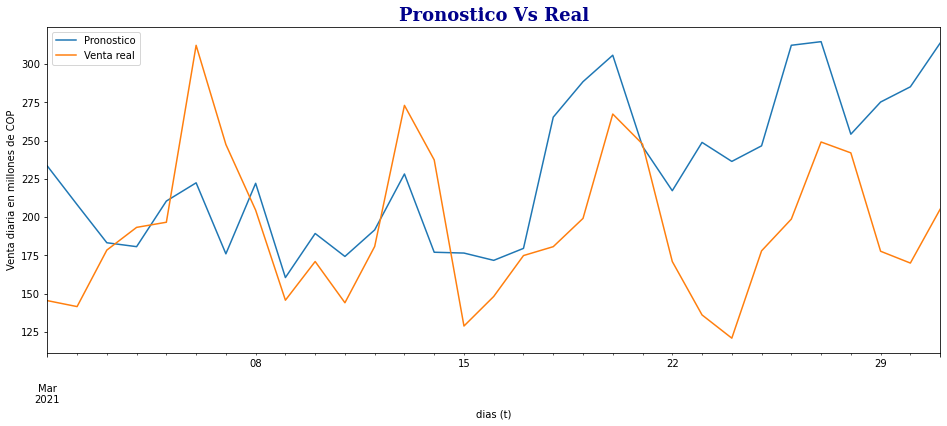

In [68]:
modelo1_test1["Prediccion"].plot(label = "Pronostico")
data_real["venta_real"].plot(label = "Venta real")

plt.ylabel("Venta diaria en millones de COP", size = 10)
plt.xlabel("dias (t)", size = 10)

plt.title("Pronostico Vs Real", 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})
plt.legend()
plt.show()

In [69]:
mod1_predict_train = modelo1.predict(data_mod1)
residuos_train   = mod1_predict_train - y

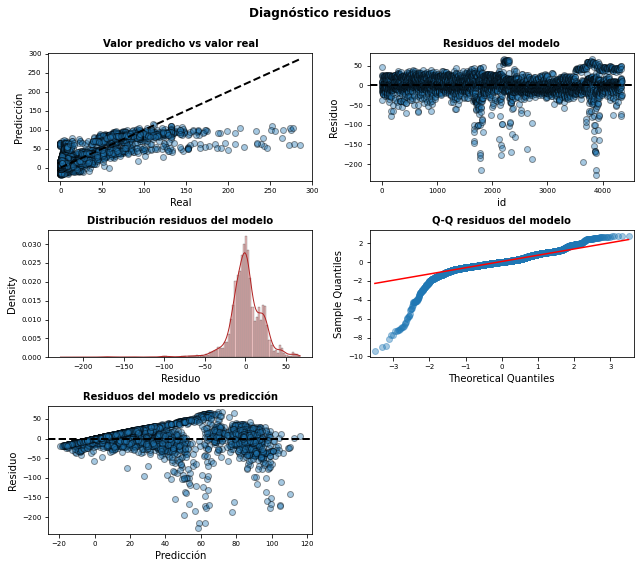

In [70]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y, mod1_predict_train , edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(mod1_predict_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [71]:
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = shapiro(residuos_train)
shapiro_test

ShapiroResult(statistic=0.8244062662124634, pvalue=0.0)

En el grafico de los datos reales Vs la predicción podemos observar que en ciertos tramos el modelo presenta comportamientos similares e incluso captura bien las tendencias. Sin embargo, también es cierto que el modelo esta sobre estimando el valor real, lo cual puede ser corregido implementando variables que capturen de mejor forma la estacionalidad.

En cuanto a la validación del modelo nos encontramos con unos residuos que pareciesen ser estacionarios en media, pero con unas observaciones outliers que no se ajustan del todo bien a los datos. El q-q plot presenta un buen indicio en la cola superior. Claramente los residuales no son normales de acuerdo con el test de Shapiro-wilk, sin embargo, es algo que es difícil de encontrar en la practica y que puede ser corregido con algunas transformaciones.


## 3.2 Modelo ARIMA

Con el objetivo de pronosticar directamente la venta diaria consolidada, se estimo un modelo ARIMA para la serie de tiempo en cuestión y los resultados fueron los siguientes:

In [72]:
y_t = train[["fecha","venta_diaria"]]
y_t["venta_diaria"] = y_t["venta_diaria"]/1000000
y_t = y_t.groupby("fecha").sum()

<AxesSubplot:xlabel='fecha'>

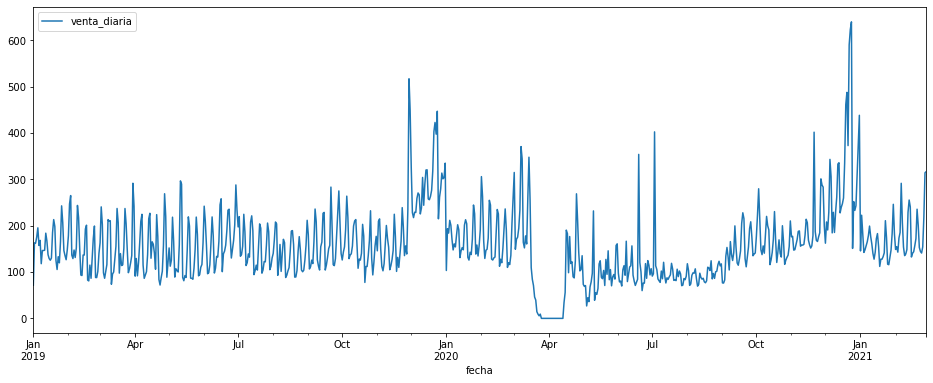

In [73]:
y_t.plot()

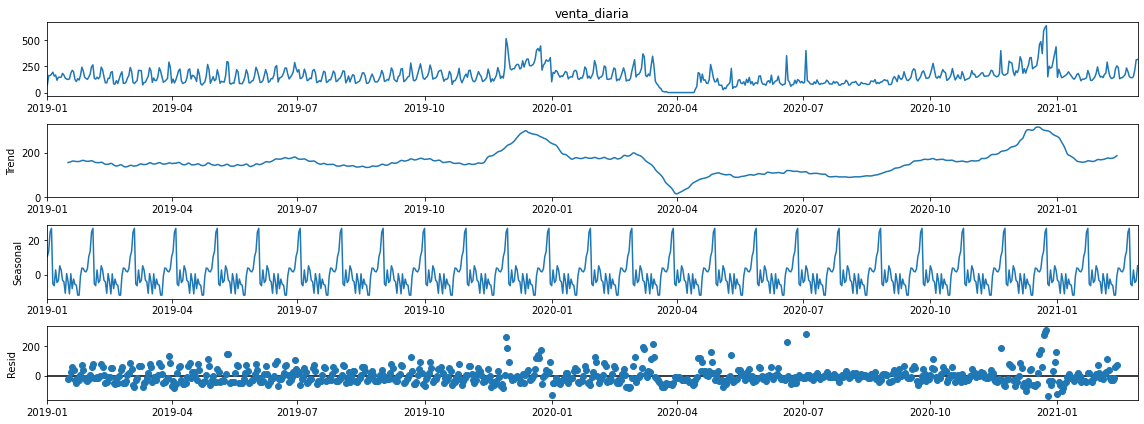

In [74]:
descomposicion = sm.tsa.seasonal_decompose(y_t['venta_diaria'],model='additive',period=30)  
descomposicion.plot()
plt.show()

En primera instancia, graficamos la serie de tiempo para los datos de entrenamiento, allí se puede observar que de cierto modo hay estacionariedad en media alrededor de los 150 millones. Luego se hizo la descomposición por factores de esta, donde resaltamos que el componente de tendencia determinística es prácticamente nulo, salvo en los periodos de diciembre en el que hay un incremento considerable que posteriormente vuelve a su nivel medio y en la época de pandemia que es un comportamiento atípico. Por otra parte, el componente estacional representa un ciclo no solo cada 12 meses, sino también incluso dentro de un mismo mes. lo cual podría indicar un microciclo durante los fines de semana. Finalmente, los residuos en la descomposición se ubican alrededor de 0, con poca variabilidad, lo cual indica un comportamiento de ruido blanco. Se procede con la estimación y validación del modelo.

In [75]:
arima_model = auto_arima(y_t.venta_diaria,start_p=0,d=0,start_q=0,max_p=4,max_d=2,max_q=4,D=0,start_Q=0,start_P=0,max_P=4,max_Q=4,max_D=2,m=12,seasonal=True)

In [76]:
arima_prediccion = pd.DataFrame(arima_model.predict(n_periods=31),index=data_real.index)
arima_prediccion.columns= ["ventas_diaria_prediccion"]

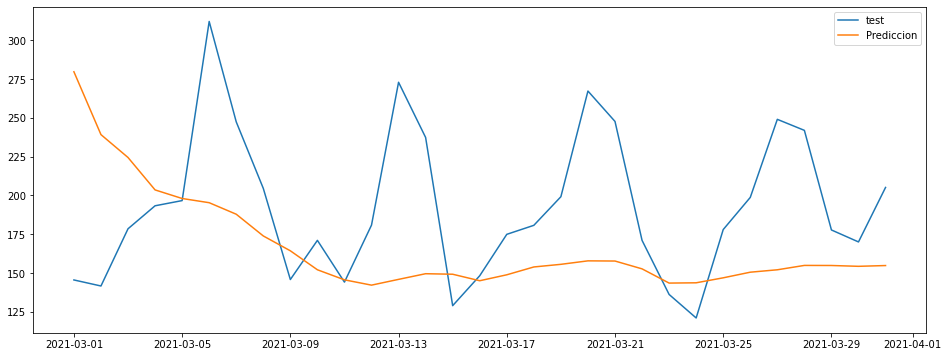

In [77]:
plt.plot(data_real,label="test")
plt.plot(arima_prediccion,label="Prediccion")
plt.legend()
plt.show()

In [78]:
sum((data_real.venta_real-arima_prediccion.ventas_diaria_prediccion)**2)/(31) ## MSE ARIMA diario consolidado

3945.4548908369757

In [79]:
sum(abs(data_real.venta_real-arima_prediccion.ventas_diaria_prediccion))/(31) ## MAE3 diario consolidado

48.693276996038854

Se estimo el modelo a partir de la función auto_arima que permite a través de cálculos computacionales seleccionar el mejor orden para los parámetros del modelo. Posteriormente, con dicho modelo se estimaron los siguientes 31 días que corresponder a los datos de testeo y se comparó con la información real. Finalmente se calcularon los estadísticos de MSE y MAE para los resultados obtenidos.

## 4. Conclusiones

- De los modelos estimados para la predicción de las ventas diarias, el modelo que menor error produce es el que se estimó a través de la metodología ARIMA. Con un RMSE de 62.8 y un MAE de 48.7. Por lo tanto, de acuerdo con el análisis realizado se constituye como el mejor modelo de predicción.

- Dada la naturaleza de la información, considero relevante que el objetivo principal no este enfocado en la predicción de las ventas diarias consolidadas, sino más bien en el pronóstico de las ventas categorizadas. En ese sentido, reunir los esfuerzos en ajustar modelos individuales en las categorías que representen el mayor flujo de ingresos como lo son Hipermercado y Calzado/Moda. Y en las demás categorías ajustar modelos menos robustos y con menor carga computacional. Entendiendo que el error de estimación producido por dichas categorías no producirá un ruido grande en la estimación consolidada.

- Una de las ventajas de discriminar la predicción por las categorías mas importantes, es que permite capturar mas adecuadamente los impactos de variables externas e incluso el impacto de los metros ocupados.

- En pro de un trabajo posterior, con un tiempo más holgado de análisis, puede ser factible el uso de metodologías más robustas de computación y estimación como redes neuronales, que permitan dar un enfoque distinto a la serie en cuestión.

## 5. Fuentes

- https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html
- https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
- https://matplotlib.org/stable/index.html
- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd